In [1]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
import requests
import matplotlib.cm as cm



In [2]:
# Dynamic stock data fetched from wikipedia list of S&P 500 companies

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    
    # The relevant table containing S&P 500 information is typically the first one
    sp500_table = df_list[0]
    
    # Extracting the columns of interest
    sp500_data = sp500_table[['Symbol', 'Security']]
    
    return sp500_data

# Call the function to get the S&P 500 data
sp500_data = get_sp500_tickers()
companies_dict = sp500_data.set_index('Symbol').to_dict()['Security']

# Display the data
print(len(companies_dict))
tickers = list(companies_dict.keys())



503


In [3]:
# Reading data from the given csv file

data = pd.read_csv('SP500_prices.csv')

In [4]:
# Data cleaning - removing columns with company names not in S&P 500

for c in data.columns[1:]:
    if c not in tickers:
        data = data.drop([c], axis=1)

# Data cleaning - datatype conversion and date filtering

data.date = pd.to_datetime(data.date)
data = data[data.date > "2018"][data.date < "2022"]
data.index = data["date"]
data.drop(columns=["date"],inplace=True)        

In [5]:
data.head()

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667


In [6]:
returns_1_day = data.pct_change()

# Removing the first row of NaN values due to pct_change function

returns_1_day = returns_1_day.iloc[1:,:]

In [7]:
# Checking for NaN values

# Check for missing values in returns_1_day
missing_values = returns_1_day.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print("Columns with Missing Values:")
print(columns_with_missing_values)

# Display total number of missing values in each column
print("\nTotal Number of Missing Values in Each Column:")
print(missing_values)

# Print missing vlues in csv file

# missing_values.to_csv('missing.csv')



# As we can see, there are columns with missing values, we will drop them

returns_1_day.dropna(axis=1,inplace=True)


Columns with Missing Values:
CARR     556
CDAY      79
CEG     1019
CTVA     350
DOW      304
FOX      299
FOXA     298
MRNA     235
OTIS     556
dtype: int64

Total Number of Missing Values in Each Column:
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 473, dtype: int64


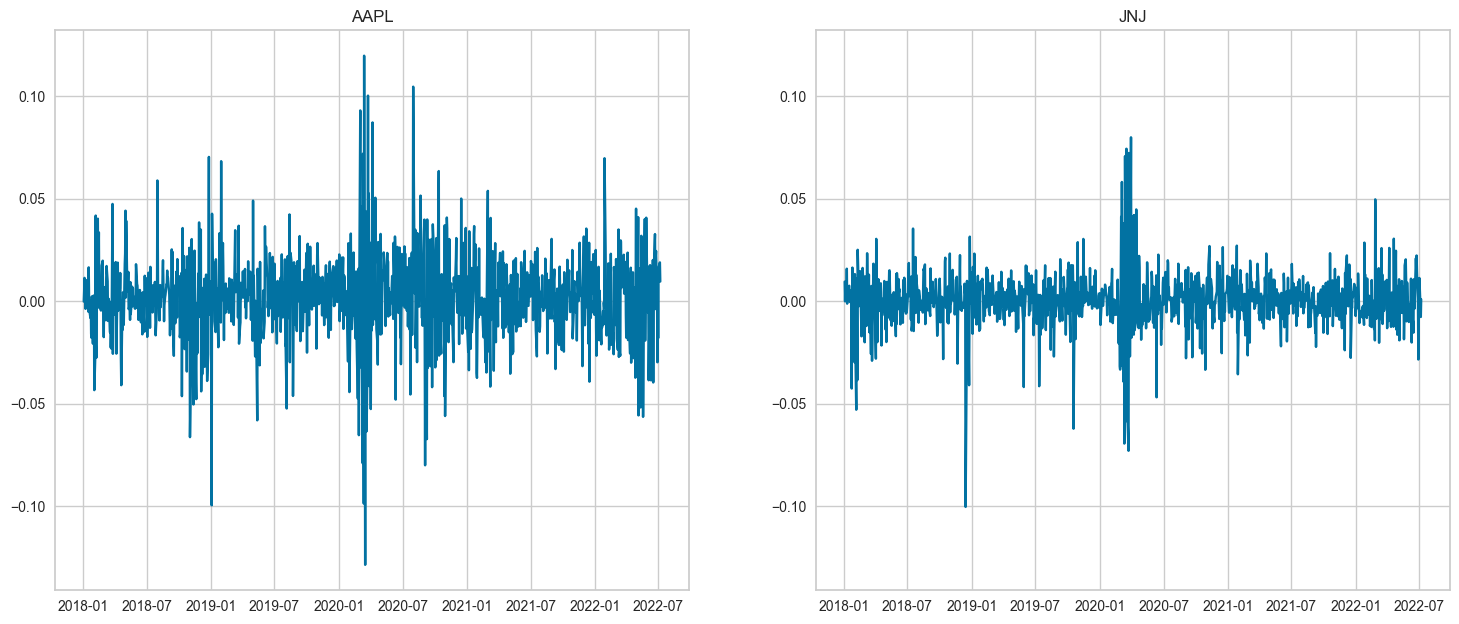

In [8]:
# Compare the movement of different stocks. 

plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(returns_1_day["AAPL"])
plt.title("AAPL")

plt.subplot(222, sharey=ax1)
plt.plot(returns_1_day["JNJ"])
plt.title("JNJ")
plt.show()

In [9]:
ret_T = returns_1_day.T

ret_T = pd.DataFrame(ret_T)
# ret_T.index = ret_T["Stock"]
ret_T.index.name = 'stock'
ret_T
# ret_T.rename(columns={"index":"Stock"},inplace=True)

date,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2022-06-22,2022-06-23,2022-06-24,2022-06-27,2022-06-28,2022-06-29,2022-06-30,2022-07-01,2022-07-05,2022-07-06
stock,,,,,,,,,,,,,,,,,,,,,
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011653,...,-0.000702,0.042179,0.022681,-0.005936,-0.029112,0.007176,0.007379,0.005482,0.011325,0.005143
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,0.004601,-0.009160,0.070878,-0.024460,-0.004425,-0.034815,-0.026861,0.035489,0.057121,0.000720
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000114,-0.000230,0.005680,0.010326,-0.005082,0.016516,...,-0.003827,0.021574,0.024517,0.000000,-0.029790,0.013024,-0.018028,0.016164,0.018930,0.009607
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007539,-0.005487,0.002930,0.010779,0.021427,0.018246,...,0.028508,0.012808,0.019338,0.005251,-0.004244,0.010820,-0.006358,0.004179,0.000845,-0.009095
ABT,0.002211,-0.001697,0.002890,-0.002882,0.001700,-0.001527,0.006832,-0.001866,-0.006798,0.009411,...,0.009865,0.007303,0.030506,-0.003380,-0.019344,0.019912,-0.004125,0.014450,-0.008347,-0.005581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0.000858,0.010180,0.005828,0.001690,-0.002651,-0.002537,-0.000727,0.013699,-0.008252,0.001929,...,-0.000986,0.007806,0.018606,0.015906,-0.023744,0.003084,-0.002811,0.028191,0.005312,-0.004261
ZBH,0.006932,-0.001441,0.009941,0.001905,-0.016083,-0.013367,-0.001959,-0.001554,-0.003440,0.006657,...,0.030128,0.010350,0.025527,-0.003307,-0.018708,0.000657,-0.013984,0.021036,-0.003542,-0.010852
ZBRA,0.019863,0.019760,0.015576,0.009951,0.030643,0.006666,0.055672,0.016341,0.001868,0.003242,...,0.006659,-0.001377,0.038667,0.002978,-0.024594,-0.012839,-0.014682,0.018336,0.009989,-0.025800


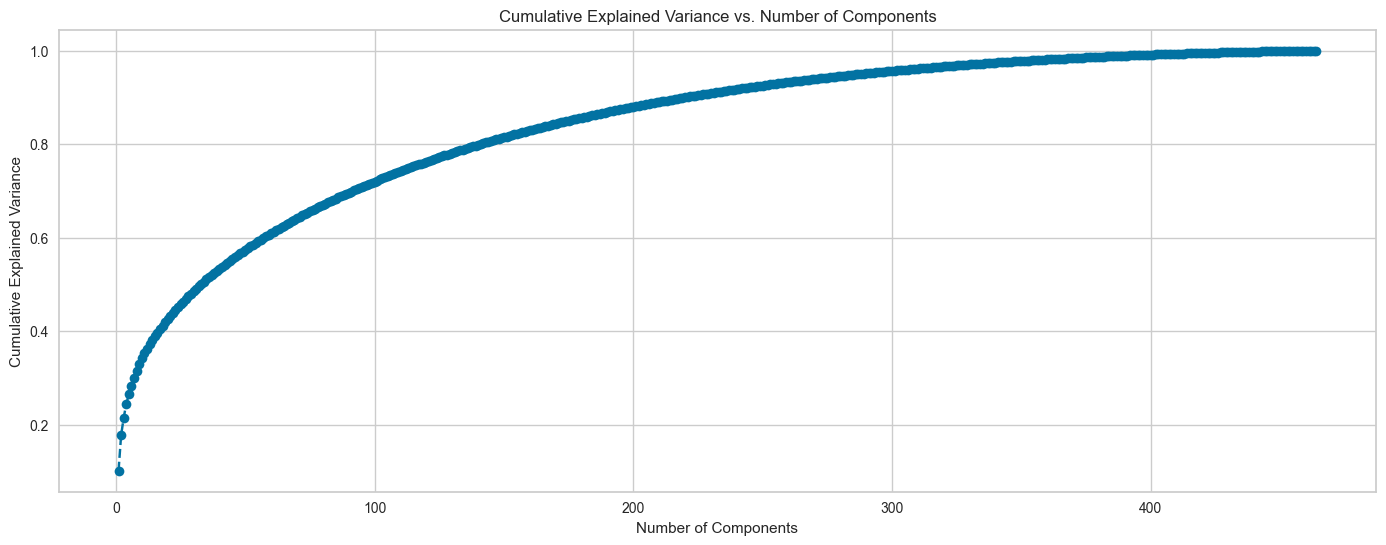

In [10]:
# Standardize the Data improve the robustness and performance of your models 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ret_T)

# PCA Dimensionality Reduction
pca = PCA(random_state=1)
pca.fit(scaled_data)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(17, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [11]:
# Check the number of components needed to explain 70% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.7:
        print(str(i) + " components needed to explain 70% of the variance")
        break

# Check the number of components needed to explain 80% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.8:
        print(str(i) + " components needed to explain 80% of the variance")
        break

# Check the number of components needed to explain 90% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.9:
        print(str(i) + " components needed to explain 90% of the variance")
        break

91 components needed to explain 70% of the variance
140 components needed to explain 80% of the variance
219 components needed to explain 90% of the variance


In [12]:
# Choose the number of components based on the plot - Here we chose 80% of varaince explained
n_components = 139

pca = PCA(n_components=n_components, random_state=1)
principal_components = pca.fit_transform(scaled_data)

# principal_components as a dataframe
principal_components = pd.DataFrame(principal_components)

print("Shape of principal_components: " + str(principal_components.shape))
principal_components


Shape of principal_components: (464, 139)


,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,-5.414068,8.703627,2.684236,-2.932096,-3.585600,-0.900658,-1.150809,0.078709,4.916820,3.734404,...,2.056235,1.144020,0.163930,0.088759,0.295620,1.977187,-0.176262,0.485961,-0.083558,-1.310134
1,26.280791,0.242298,-23.855849,10.238743,0.492448,-4.776176,-8.459720,9.200473,1.785613,-8.165248,...,1.052195,-3.621157,0.788933,-0.074286,2.808533,1.919517,0.142839,1.697242,1.604060,-2.377803
2,-3.721772,13.751482,2.847327,0.865995,2.178129,-2.006688,-0.446821,-0.002384,-2.367854,-2.066795,...,-1.596371,0.698040,0.972852,0.458205,1.754880,-2.474925,-1.841844,-1.445850,-1.116693,2.344700
3,-7.452531,-2.226275,6.325372,-3.594183,-4.084260,-4.467812,-3.256575,5.351997,-0.433365,3.083540,...,1.140350,1.108976,-1.131439,-0.522470,-1.646235,1.860897,3.823417,-1.319428,-3.196982,1.482970
4,-10.381086,4.719474,3.246370,-3.066249,-4.940217,-3.726899,-1.617166,2.177905,2.489248,2.944729,...,-1.186875,-0.926466,0.295754,-0.478240,0.907836,-0.102017,-1.593273,-0.602596,-1.218252,-0.327815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,-6.273669,-2.050125,-2.844427,1.987778,-0.776510,1.372991,-0.702774,-2.340286,0.121008,-1.455539,...,-0.455329,-0.101468,-0.105772,1.522395,-0.589522,1.203066,-0.229075,0.388165,1.442914,-1.956009
460,-2.617840,-0.687842,-1.605562,2.568847,-4.153007,-2.979247,-2.518877,1.968570,4.183958,4.592576,...,-0.818643,-2.045102,0.608178,-1.076139,-0.415311,-1.234121,0.668895,1.386721,1.821355,0.758332
461,2.942453,14.695696,2.154723,-0.451507,1.243286,3.852549,-1.111238,-2.196086,1.344865,0.976333,...,0.610167,-1.703621,-1.145969,1.516179,0.931788,-2.604704,-0.648248,-1.151311,0.987569,0.393779
462,17.819172,-8.872414,-5.728822,-7.448765,-6.094039,-4.776780,10.588974,-0.295350,-6.613202,2.488391,...,0.115447,0.785539,0.119700,-0.114674,0.430121,0.270560,0.038121,-0.051669,0.972642,0.072668


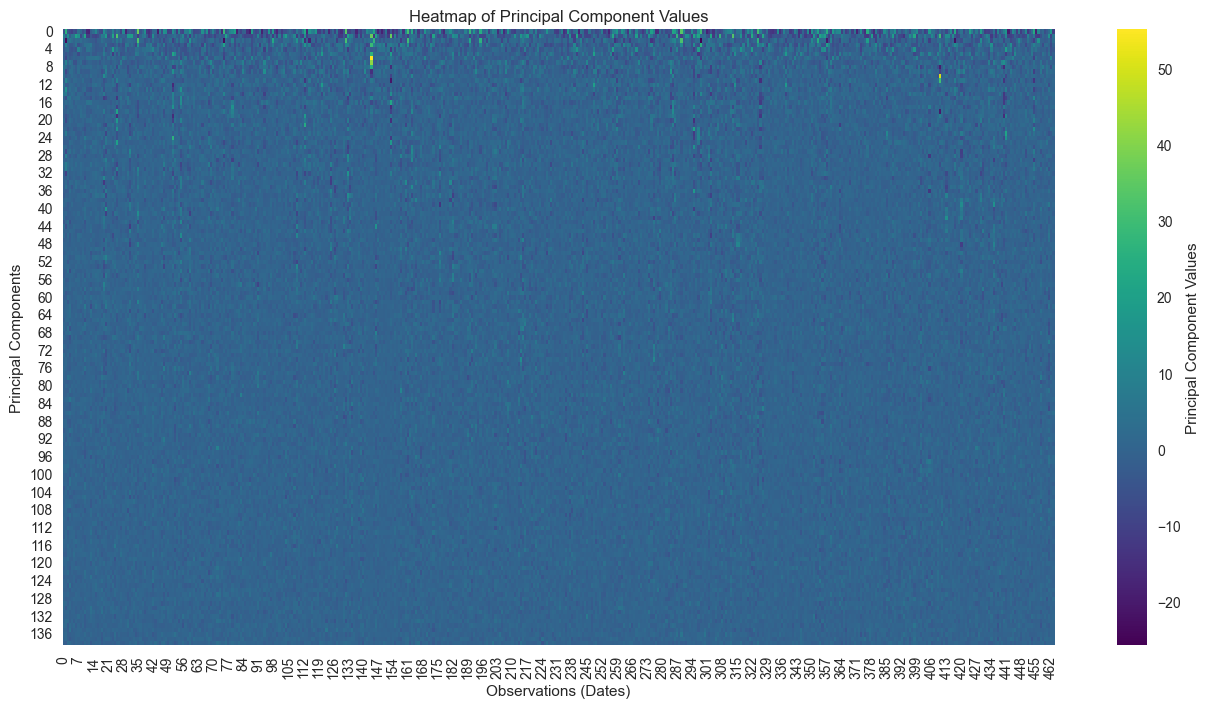

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming principal_components is a DataFrame with 160 columns
# You may need to adjust the column names based on your data``

# Create a heatmap to visualize the values of principal components
plt.figure(figsize=(16, 8))
sns.heatmap(principal_components.T, cmap='viridis', cbar_kws={'label': 'Principal Component Values'})
plt.title('Heatmap of Principal Component Values')
plt.xlabel('Observations (Dates)')
plt.ylabel('Principal Components')
plt.show()

# heatmap due to the number of components not interpretable (or useful) for our analysis

In [14]:
clf = DBSCAN(eps=12, min_samples=5)

clf.fit(principal_components)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

clustered = clf.labels_ 

n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


from sklearn import metrics

print(f"Silhouette Coefficient: {metrics.silhouette_score(principal_components, labels):.3f}")

Estimated number of clusters: 5
Estimated number of noise points: 405
Silhouette Coefficient: -0.186


In [15]:
eps_value = 12
min_samples_value = 5

clf = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clf.fit(principal_components)

# Extract cluster labels and remove noise points
labels = clf.labels_
clustered_mask = (labels != -1)
# print(clustered_mask)
clustered_data = principal_components[clustered_mask]
clustered_labels = labels[clustered_mask]

# Calculate the number of clusters (excluding noise)
n_clusters_ = len(set(clustered_labels))
# Calculate the number of noise points
n_noise_ = len(labels) - len(clustered_data)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Calculate silhouette score for clustered data
silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)
print(f"Silhouette Coefficient (excluding noise): {silhouette_avg:.3f}")


# Silhouette Coefficient is already quite good but lets try to improve it by tuning the hyperparameters!


Estimated number of clusters: 5
Estimated number of noise points: 405
Silhouette Coefficient (excluding noise): 0.481


In [16]:
clustered_series = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]
# print("Clusters formed: %d" % len(ticker_count_reduced))
# print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

In [17]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

eps_values = np.arange(5, 30, 0.1)
min_samples_values = list(range(3, 10))  # We want to test min_samples values starting 2

best_eps = None
best_min_samples = None
best_silhouette_score = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        clf = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clf.fit_predict(principal_components)
        unique_labels = set(labels)

        if len(unique_labels) <= 4 or len([label for label in labels if label != -1]) <= 120:  # We want at least 4 clusters
            pass
        else:
            clustered_mask = (labels != -1)
            clustered_data = principal_components[clustered_mask]
            clustered_labels = labels[clustered_mask]

            # Calculate silhouette score
            silhouette_avg = metrics.silhouette_score(clustered_data, clustered_labels)

            # Update best parameters if silhouette score is higher
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette_score}")

# Fit DBSCAN with best parameters
best_clf = DBSCAN(eps=best_eps, min_samples=best_min_samples)

best_labels = best_clf.fit_predict(principal_components)
n_clusters_ = len(set(best_labels)) - (1 if -1 in best_labels else 0)

# This is used to make it unifrom with the previous code (I'll make it more unform later when we submit the code)
clustered = best_clf.labels_


best_clustered_mask = (best_labels != -1)
best_clustered_data = principal_components[best_clustered_mask]
best_clustered_labels = best_labels[best_clustered_mask]

n_noise_ = list(best_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Silhouette Coefficient: {best_silhouette_score:.3f}")


Best eps: 13.59999999999997
Best min_samples: 3
Best Silhouette Score: 0.33871732448133207
Estimated number of clusters: 16
Estimated number of noise points: 339
Silhouette Coefficient: 0.339


In [18]:
clustered_series = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns_1_day.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 16
Pairs to evaluate: 1654


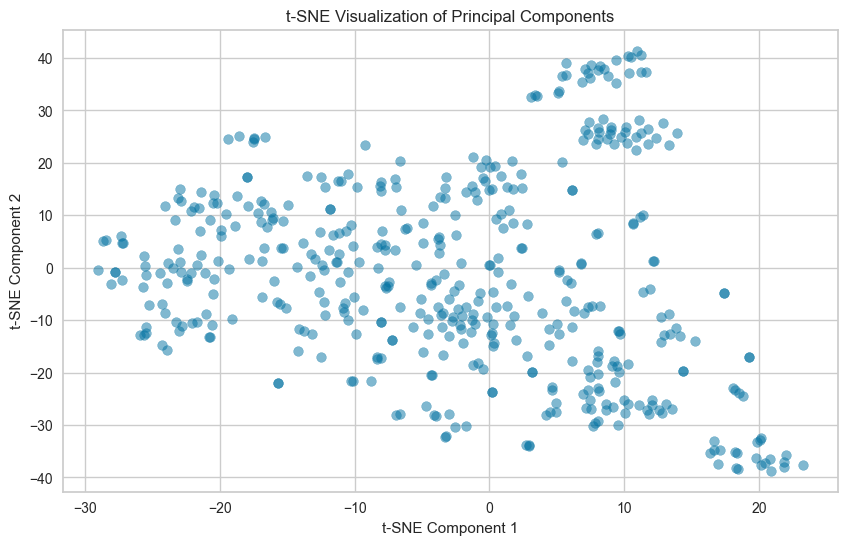

In [19]:
# Initialize t-SNE with 2 components for 2D visualization
tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1)

# Fit and transform the principal components
tsne_result = tsne.fit_transform(principal_components)
#print("Shape of tsne_result: " + str(tsne_result.shape))
#print(tsne_result)

# Create a scatter plot of the t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Principal Components')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

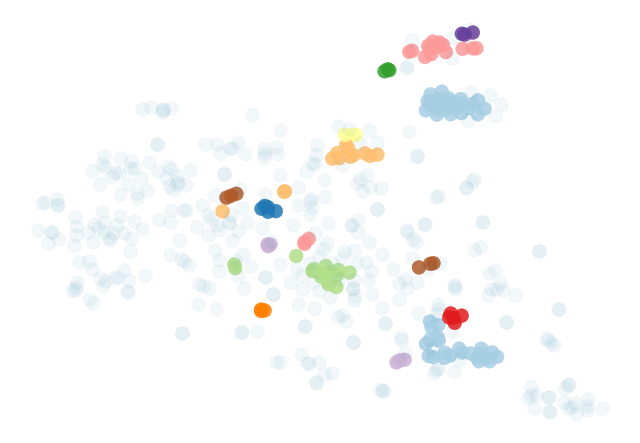

In [20]:
plt.figure(1, facecolor='white')
plt.clf()

plt.scatter(
    tsne_result[(clustered!=-1), 0],
    tsne_result[(clustered!=-1), 1],
    s=100,
    alpha=0.85,
    c=clustered[clustered!=-1],
    cmap=cm.Paired
)

plt.scatter(
    tsne_result[(clustered_series_all==-1).values, 0],
    tsne_result[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

#plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.axis("off")
plt.savefig('DBSCAN_cluster.svg',format='svg', bbox_inches='tight')
plt.show()

# print(tsne_result)


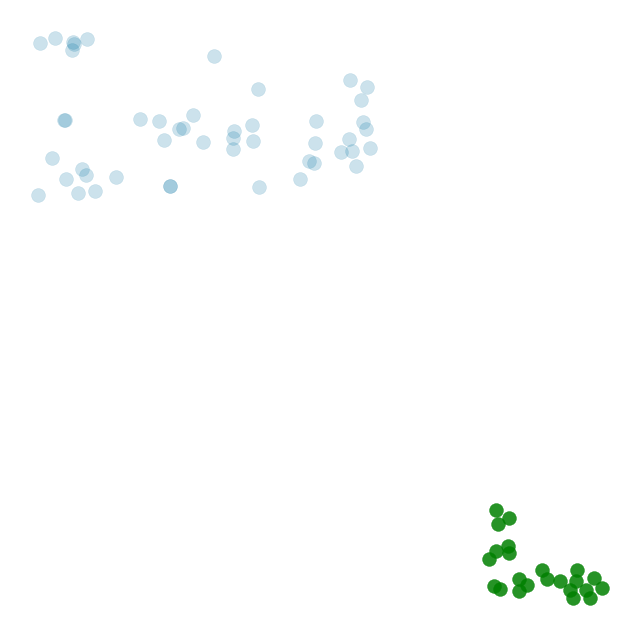

In [21]:
plt.figure(8,figsize=(8, 8), facecolor='white')
plt.clf()

# First scatter plot
plt.scatter(
    tsne_result[(clustered == 1), 0],
    tsne_result[(clustered == 1), 1],
    s=100,
    alpha=0.85,
    c='green',
    cmap=cm.Paired
)

# Second scatter plot with filtering
filtered_data = tsne_result[
    (clustered_series_all != 1).values & 
    (tsne_result[:, 0] >= -20) & 
    (tsne_result[:, 0] <= 0) & 
    (tsne_result[:, 1] >= 10) & 
    (tsne_result[:, 1] <= 30)
]

plt.scatter(
    filtered_data[:, 0],
    filtered_data[:, 1],
    s=100,
    alpha=0.2
)

# Uncomment the lines below if you want to add title, turn off axis, and save the plot.
# plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')
plt.axis("off")
plt.savefig('DBSCAN_cluster_detail.svg', format='svg', bbox_inches='tight')

plt.show()

In [22]:
DBSCAN_cluster =[]
# print out the stock names that are in each cluster
for i in range(len(ticker_count_reduced)):
    print("Cluster " + str(i+1) + " (" + str(len(clustered_series[clustered_series==i])) + " stocks)")
    for name in clustered_series[clustered_series==i].index:
        print(companies_dict[name], end=", ")
        DBSCAN_cluster.append({"Cluster": i,"Stock":name,"Stock_Name":companies_dict[name]})
    print("\n")
    # print(clustered_series[clustered_series==i].index.tolist())
    # print(", ".join(clustered_series[clustered_series==i].index.tolist()))
    # print()


Cluster 1 (23 stocks)
Ameren, American Electric Power, Atmos Energy, American Water Works, CMS Energy, Dominion Energy, DTE Energy, Duke Energy, Consolidated Edison, Eversource, Entergy, Evergy, Exelon, Alliant Energy, NextEra Energy, NiSource, Public Service Enterprise Group, Pinnacle West, PPL Corporation, Southern Company, Sempra Energy, WEC Energy Group, Xcel Energy, 

Cluster 2 (23 stocks)
Aflac, Ameriprise Financial, Bank of America, Citigroup, Citizens Financial Group, Comerica, Fifth Third Bank, Globe Life, Goldman Sachs, Huntington Bancshares, JPMorgan Chase, KeyCorp, Loews Corporation, MetLife, Morgan Stanley, M&T Bank, Principal Financial Group, PNC Financial Services, Prudential Financial, Regions Financial Corporation, Truist, U.S. Bank, Zions Bancorporation, 

Cluster 3 (5 stocks)
Arthur J. Gallagher & Co., Aon, Brown & Brown, Marsh McLennan, Willis Towers Watson, 

Cluster 4 (15 stocks)
Ametek, Amphenol, Dover Corporation, Emerson Electric, Eaton Corporation, Fortive, Ho

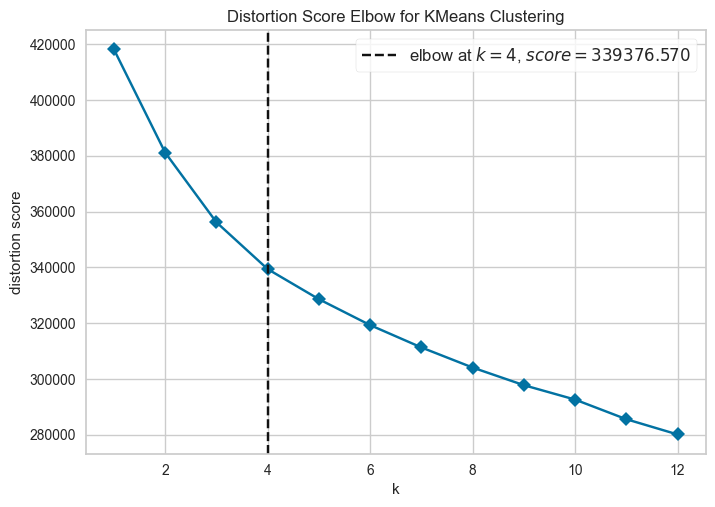

In [23]:
# As a contrast we also want to use KMeans to cluster the stocks



# Create k-Means model and find optimal number of clusters with the elbow method

model = KMeans(random_state = 1)
visualizer = KElbowVisualizer(
    model, k=(1,13), timings=False, random_state = 1
)

visualizer.fit(principal_components)        
visualizer.show()
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, random_state=1)
cluster_assignments = kmeans.fit_predict(principal_components)

In [24]:
# Add the cluster assignments to a copy of the returns dataframe

returns_clustered = ret_T.copy()
returns_clustered['Cluster'] = cluster_assignments

# Explore Clusters
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = returns_clustered[returns_clustered['Cluster'] == cluster_id].drop(columns=['Cluster'])
    mean_returns = cluster_stocks.mean(axis=1)
    #print(f'\nCluster {cluster_id + 1}' + " (" + str(mean_returns.count()) + " stocks)")
    # print(f'Total Mean Return: {mean_returns.mean()}')
    for name, value in mean_returns.items():
        print(companies_dict[name])


AbbVie
Abbott
Accenture
Archer-Daniels-Midland
Automated Data Processing
Ameren
American Electric Power
AES Corporation
Assurant
Arthur J. Gallagher & Co.
Allstate
Allegion
Amcor
Amgen
American Tower
Aon
Air Products and Chemicals
Alexandria Real Estate Equities
Atmos Energy
AvalonBay Communities
American Water Works
AutoZone
Ball Corporation
Baxter International
Becton Dickinson
Biogen
Bristol Myers Squibb
Broadridge Financial Solutions
Brown & Brown
Boston Scientific
Boston Properties
Conagra Brands
Cardinal Health
Chubb Limited
Cboe Global Markets
Crown Castle
Church & Dwight
CH Robinson
Charter Communications
Cigna
Cincinnati Financial
Colgate-Palmolive
Clorox
Comcast
CME Group
CMS Energy
Centene Corporation
CenterPoint Energy
CooperCompanies
Costco
Campbell Soup Company
Camden Property Trust
Cisco
Cintas
Cognizant
CVS Health
Dominion Energy
Dollar General
Quest Diagnostics
DR Horton
Danaher Corporation
Digital Realty
Dollar Tree
Domino's
DTE Energy
Duke Energy
DaVita Inc.
Ecolab
C

In [25]:
n_clusters 

4

In [26]:
# Create and fit the model with the optimal number of clusters from above
model = KMeans(n_clusters = n_clusters)
model.fit(ret_T)

labels = model.predict(ret_T)

# create a DataFrame aligning labels & companies
clusters = pd.DataFrame({'cluster': labels, 'ticker': returns_1_day.columns})

for i in clusters.index:
    clusters.loc[i,"company"] = companies_dict[clusters.loc[i,"ticker"]]

# display df sorted by cluster labels. Would you say that the clustering makes sense?
clusters.sort_values('cluster').reset_index(drop=True)
# clusters.to_csv('clusters.csv')

,cluster,ticker,company
0,0,HES,Hess Corporation
1,0,DVN,Devon Energy
2,0,HAL,Halliburton
3,0,APA,APA Corporation
4,0,BKR,Baker Hughes
...,...,...,...
459,3,HD,Home Depot (The)
460,3,HAS,Hasbro
461,3,GWW,W. W. Grainger
462,3,HSY,Hershey's


In [27]:
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = ret_T[ret_T.index.isin(clusters[clusters['cluster']==cluster_id]['ticker'])]
    mean_returns = cluster_stocks.mean(axis=1)
    volatility = cluster_stocks.std(axis=1)
    print(f'\nCluster {cluster_id + 1} Mean Returns:')
    print(f'Total Mean Return: {mean_returns.mean()}')
    print(f'Mean Volatility: {volatility.mean()}')
    print(f'Size: {mean_returns.count()} Stocks')
    print(mean_returns.sort_values(ascending=False).head())


Cluster 1 Mean Returns:
Total Mean Return: 0.0007225093215853258
Mean Volatility: 0.0349079139149578
Size: 13 Stocks
stock
HES    0.001220
DVN    0.001086
MRO    0.000987
APA    0.000922
COP    0.000888
dtype: float64

Cluster 2 Mean Returns:
Total Mean Return: 0.0010176934303785285
Mean Volatility: 0.025168536079854614
Size: 83 Stocks
stock
ENPH    0.005142
TSLA    0.002964
AMD     0.002338
ETSY    0.002059
FTNT    0.002049
dtype: float64

Cluster 3 Mean Returns:
Total Mean Return: 0.0003912324387935601
Mean Volatility: 0.025501731140481536
Size: 149 Stocks
stock
CZR    0.001345
PWR    0.001290
CF     0.001067
LYV    0.001045
MOS    0.001032
dtype: float64

Cluster 4 Mean Returns:
Total Mean Return: 0.000562083874552117
Mean Volatility: 0.018283827867582984
Size: 219 Stocks
stock
LLY     0.001459
MOH     0.001448
WST     0.001211
POOL    0.001176
AZO     0.001132
dtype: float64


In [28]:
clusters.groupby("cluster").count()

,ticker,company
cluster,,
0,13,13
1,83,83
2,149,149
3,219,219


We see the problem with KMeans clustering. It will always find clusters, even if the data doesn't have any clusters. In this case, we see that the clusters are not very meaningful. We can see that some of the stocks in each cluster are not very similar to each other. 